In [1]:
# Import libraries 
from laspy.file import File
import open3d as o3d

from skimage import io
from skimage.filters import threshold_local
from skimage.measure import label, regionprops

from matplotlib import pyplot as plt
from scipy import optimize
import pandas as pd
import numpy as np
import cv2
import math
import os

In [2]:
# Extract traits: Canopy structure indexs of each plot.
def Extract_traits(folder_path):
    # Calculate Canopy structure indexs
    FT_area_index = []
    curvature_index = []
    canopy_cover_index = []
    file_names = []
    for i in range(len(os.listdir(folder_path))):
        file_name = 'plot_'+str(i+1) + '.png'
        file_names.append(file_name)
        # Read img.
        img = io.imread(os.path.join(folder_path,file_name))
        # Fourier Transform.
        # Spectrogram
        fft2 = np.fft.fft2(img)
        shift2center = np.fft.fftshift(fft2)
        # Log Transform.
        log_fft2 = np.log(1 + np.abs(fft2))
        log_shift2center = np.log(1 + np.abs(shift2center))
        X = []
        Y = []
        for j in range(log_shift2center.shape[1]):
            i = int(log_shift2center.shape[0]/log_shift2center.shape[1] * j) 
            x = np.sqrt(i**2+j**2) - np.sqrt((log_shift2center.shape[0]/2)**2+(log_shift2center.shape[1]/2)**2)
            y = log_shift2center[i,j]
            X.append(x)
            Y.append(y)
        X = np.array(X)
        Y = np.array(Y)
        # Gaussian Fitting
        def gaussian(x, amplitude, mean, stddev): 
            return amplitude * np.exp(-((x - mean)/4/stddev)**2) 
        popt, pcov = optimize.curve_fit(gaussian, X, Y)
        Y = gaussian(X, *popt)
        # Canopy Structure index
        FT_area = np.trapz(Y,X)
        FT_area_index.append(FT_area)
        # Curvature 
        dx_dt = np.gradient(X) # V(x)
        dy_dt = np.gradient(Y) # V(y)
        velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)]) # Speed vector.
        ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt) # Speed
        tangent = np.array([1/ds_dt] * 2).transpose() * velocity # The unit tangent vector.
        # Take the derivative of the tangent vector and divide by its length to get the unit normal vector.
        tangent_x = tangent[:, 0]
        tangent_y = tangent[:, 1]
        deriv_tangent_x = np.gradient(tangent_x)
        deriv_tangent_y = np.gradient(tangent_y)
        dT_dt = np.array([ [deriv_tangent_x[i], deriv_tangent_y[i]] for i in range(deriv_tangent_x.size)])
        length_dT_dt = np.sqrt(deriv_tangent_x * deriv_tangent_x + deriv_tangent_y * deriv_tangent_y)
        normal = np.array([1/length_dT_dt] * 2).transpose() * dT_dt
        d2s_dt2 = np.gradient(ds_dt) # Acceleration
        d2x_dt2 = np.gradient(dx_dt)
        d2y_dt2 = np.gradient(dy_dt)
        curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
        curvature_max = np.max(curvature)
        curvature_index.append(curvature_max)
        # Canopy cover
        thresh = threshold_local(img,block_size=175)
        mask = img > thresh
        canopy_area = 0
        label_img = label(mask)
        for region in regionprops(label_img):
            area = region.area
            canopy_area = canopy_area+area
        canopy_cover = canopy_area/(img.shape[0]*img.shape[1])
        canopy_cover_index.append(canopy_cover)
    
    # rows&columns
    row_index=[]
    column_index=[]
    # The number can be calculated in GUI.
    for i in range(27):
        for j in range(6):
            row_index.append(i+1)
            column_index.append(j+1)
        
    # Write to csv files.
    # Plot traits.
    dt = pd.DataFrame({'file_names':file_names,'row_id':row_index,'column_id':column_index,
                       'Canopy_index':FT_area_index,'curvature_index':curvature_index,'canopy_cover_index':canopy_cover_index})
    save_path = os.path.join(folder_path,'Canopy_traits.csv')
    dt.to_csv(save_path,encoding="gbk")
    return(save_path)

In [3]:
def Biomass_Calculate_Voxel(x,y,z):
    #Voxel Size.
    dist = 0.05 #5cm
    sizeofvoxel = [dist, dist, dist]
    # Length,Width and Height
    pixelWidth = sizeofvoxel[0]
    pixelLong = sizeofvoxel[1]
    pixelHeight = sizeofvoxel[2]
    # Calculate the number.
    rows = np.ceil((np.max(y)-np.min(y))/pixelWidth)
    cols = np.ceil((np.max(x)-np.min(x))/pixelLong)
    heis = np.ceil((np.max(z)-np.min(z))/pixelHeight)
    # Offset removal
    xOffset = x-np.min(x)
    yOffset = y-np.min(y)
    zOffset = z-np.min(z)
    points = np.column_stack([xOffset,yOffset,zOffset])
    points = np.array(points)
    # Calculate the number of voxel which has more than 10 points.
    number = 0
    for i in range(0,int(cols)):
        for j in range(0,int(rows)):
            for n in range(2,int(heis)):
                sub1 = points[np.where((points[:,0]>=i*dist)&(points[:,0]<(i+1)*dist))]
                sub2 = sub1[np.where((sub1[:,1]>=j*dist)&(sub1[:,1]<(j+1)*dist))]
                sub3 = sub2[np.where((sub2[:,2]>=n*dist)&(sub2[:,2]<(n+1)*dist))]
                if (sub3.shape[0] > 1):
                    number = number + 1
    ThreeD_voxel_index = number/(rows*cols*heis)
    return(ThreeD_voxel_index)

def Biomass_Calculate_Profile(x,y,z):
    # Offset removal
    xOffset = x-np.min(x)
    yOffset = y-np.min(y)
    zOffset = z-np.min(z)
    points = np.column_stack([xOffset,yOffset,zOffset])
    points = np.array(points)
    # New coords:(x,y,z).
    x = points[:,0]
    y = points[:,1]
    z = points[:,2]
    pixelWidth = 0.01 #1cm
    rows = np.ceil((np.max(z)-np.min(z))/pixelWidth)
    # k∈(-3.25,2.25),step = 0.05
    k = 1
    Pt = points.shape[0]
    result = []
    Pcs = 0
    for i in range(0,int(rows)):
        one_layer = points[np.where((points[:,2]>=i*pixelWidth)&(points[:,2]<(i+1)*pixelWidth))]
        one_layer_number = one_layer.shape[0]
        Pcs = Pcs + one_layer_number
        sub = math.exp(k*Pcs/Pt) * (one_layer_number/Pt)
        result.append(sub)
    ThreeD_profile_index = np.sum(np.array(result))
    return(ThreeD_profile_index)

def mesh_calculate(x,y,z):
    points_refined = zip(x,y,z)
    # Write to pcd.
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_refined)
    # Downsampling and Alpha shapes
    downpcd = pcd.voxel_down_sample(voxel_size=0.1)
    downpcd.estimate_normals()
    alpha = 0.05
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(downpcd, alpha)
    mesh.compute_vertex_normals()
    mesh_area = mesh.get_surface_area()
    return(mesh_area)

In [4]:
def plot_level_traits(folder_path):
    filenames = []    
    voxel_index = []
    profile_index = []
    mesh_index = []
    for i in range(len(os.listdir(folder_path))):
        # File name.
        filename = 'plot_'+str(i+1)+'.las'
        filenames.append(filename)
        # Read single plot.
        inFile = File(os.path.join(folder_path,filename), mode='r')
        points = inFile.points
        x,y,z = inFile.x,inFile.y,inFile.z
        # Remove offset
        x = x - np.min(x)
        y = y - np.min(y)
        z = z - np.min(z)
        # Canopy point cloud.
        Canopy_x = x[np.where(z>np.max(z)*0.5)]
        Canopy_y = y[np.where(z>np.max(z)*0.5)]
        Canopy_z = z[np.where(z>np.max(z)*0.5)]
        # calculate
        voxel = Biomass_Calculate_Voxel(Canopy_x,Canopy_y,Canopy_z)
        voxel_index.append(voxel)
        profile = Biomass_Calculate_Profile(Canopy_x,Canopy_y,Canopy_z)
        profile_index.append(profile)
        try:
            mesh_area = mesh_calculate(Canopy_x,Canopy_y,Canopy_z)
            mesh_index.append(mesh_area)
        except RuntimeError:
            mesh_area = 'null'
            mesh_index.append(mesh_area)
    #Write to csv files.
    dt = pd.DataFrame({'filenames':filenames,'voxel_index':voxel_index,
                       'profile_index':profile_index,'Canopy_surface_index':mesh_index})
    save_path = os.path.join(folder_path,'plot_indexs.csv')
    dt.to_csv(save_path,encoding="gbk")
    
    return(save_path)

In [5]:
def fitting_data(path1,path2,path3):
    def FT_for_XY(img):
        fft2 = np.fft.fft2(img)
        shift2center = np.fft.fftshift(fft2)
        # Log Transform.
        log_fft2 = np.log(1 + np.abs(fft2))
        log_shift2center = np.log(1 + np.abs(shift2center))
        X = []
        Y = []
        for j in range(log_shift2center.shape[1]):
            i = int(log_shift2center.shape[0]/log_shift2center.shape[1] * j) 
            x = np.sqrt(i**2+j**2) - np.sqrt((log_shift2center.shape[0]/2)**2+(log_shift2center.shape[1]/2)**2)
            y = log_shift2center[i,j]
            X.append(x)
            Y.append(y)
        # Diagonal data
        X = np.array(X)
        Y = np.array(Y)
        # Gaussian Fitting
        def gaussian(x, amplitude, mean, stddev): 
            return amplitude * np.exp(-((x - mean)/4/stddev)**2) 
        popt, pcov = optimize.curve_fit(gaussian, X, Y)
        Y = gaussian(X, *popt)
        # std = popt[2]
        return(X,Y)
    # Repeat 1.
    img1 = io.imread(path1)
    x1,y1 = FT_for_XY(img1)
    # Repeat 2.
    img2 = io.imread(path2)
    x2,y2 = FT_for_XY(img2)
    # Repeat 3.
    img3 = io.imread(path3)
    x3,y3 = FT_for_XY(img3)
    
    x = (x1+x2+x3)/3
    y = (y1+y2+y3)/3
    return(x,y)

In [6]:
# Step 1: Extract canopy traits.
images_folder = r"C:\Users\Pix4D-WS\Desktop\test\results\plotimages"
# Calculate and save.
Extract_traits(images_folder)

'C:\\Users\\Pix4D-WS\\Desktop\\test\\results\\plotimages\\Canopy_traits.csv'

In [7]:
# Step 2: Extract plot-level traits: 3DVI,3DPI,Canopy surface index.
point_cloud_folder = r"C:\Users\Pix4D-WS\Desktop\test\results\plot_point_cloud"
# Calculate and save.
plot_level_traits(point_cloud_folder)

'C:\\Users\\Pix4D-WS\\Desktop\\test\\results\\plot_point_cloud\\plot_indexs.csv'

In [8]:
# N0
path1 = r"C:\Users\Pix4D-WS\Desktop\test\N0_1.png"
path2 = r"C:\Users\Pix4D-WS\Desktop\test\N0_2.png"
path3 = r"C:\Users\Pix4D-WS\Desktop\test\N0_3.png"
x_1,y_1 = fitting_data(path1,path2,path3)

In [9]:
# N180
path1 = r"C:\Users\Pix4D-WS\Desktop\test\N180_1.png"
path2 = r"C:\Users\Pix4D-WS\Desktop\test\N180_2.png"
path3 = r"C:\Users\Pix4D-WS\Desktop\test\N180_3.png"
x_2,y_2 = fitting_data(path1,path2,path3)

In [10]:
# N270
path1 = r"C:\Users\Pix4D-WS\Desktop\test\N270_1.png"
path2 = r"C:\Users\Pix4D-WS\Desktop\test\N270_2.png"
path3 = r"C:\Users\Pix4D-WS\Desktop\test\N270_3.png"
x_3,y_3 = fitting_data(path1,path2,path3)

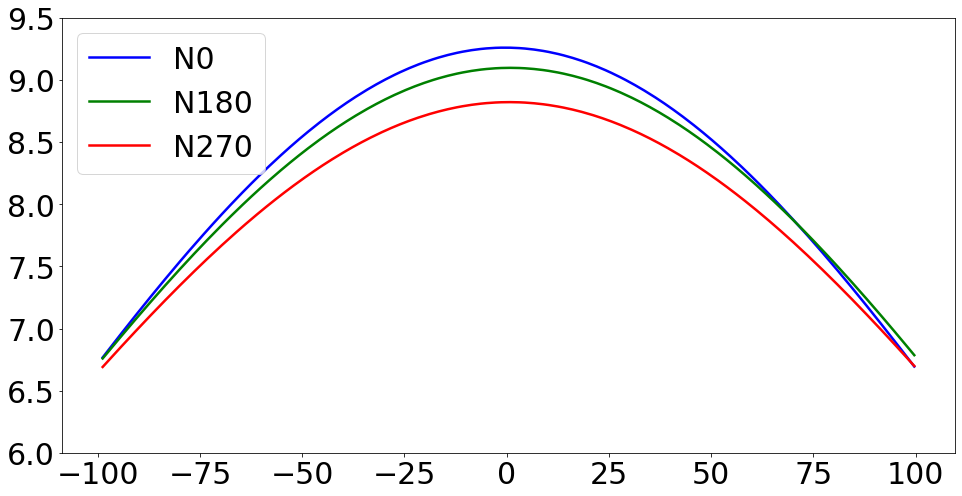

In [11]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes()
# N0
plt.plot(x_1[np.where(np.abs(x_1)<100)],y_1[np.where(np.abs(x_1)<100)],'b',label='N0',lw=2.5)
# N180
plt.plot(x_2[np.where(np.abs(x_2)<100)],y_2[np.where(np.abs(x_2)<100)],'g',label='N180',lw=2.5)
# N270
plt.plot(x_3[np.where(np.abs(x_3)<100)],y_3[np.where(np.abs(x_3)<100)],'r',label='N270',lw=2.5)

plt.xticks(fontsize=30)
plt.yticks(np.linspace(6.0,9.5,8),fontsize=30)
plt.legend(loc='upper left',fontsize=30)
plt.show()